In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file
from yfetch import get_stock_history

In [11]:
# Define the ticker symbol
symbol = 'MAGS'

# Get the historical prices for this ticker
history = get_stock_history(symbol, period='5y', interval='1wk')

Loaded cached history for MAGS (111 rows)


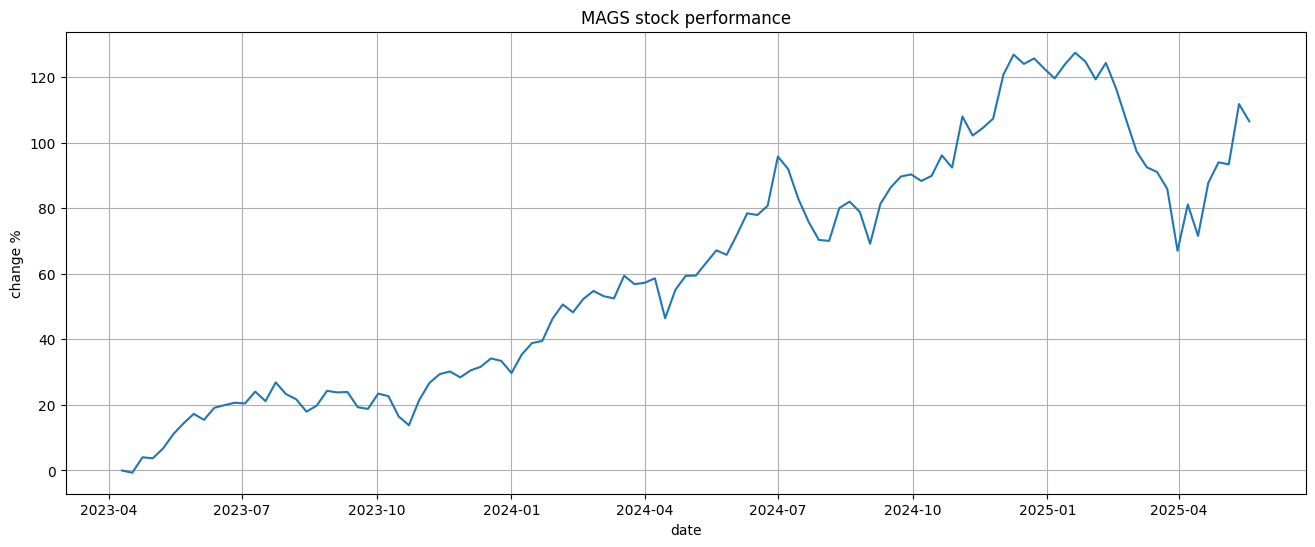

In [12]:
plt.figure(figsize=(16,6))
plt.plot((history.Close / history.Close.iloc[0]) * 100 - 100)
plt.title(symbol + ' stock performance')
plt.xlabel('date')
plt.ylabel('change %')
plt.grid()
plt.show()

In [13]:

gap = (0.5 / 55) * 100 # %

option_prices = {
    1: [56/0.49, 57/0.52, 56/0.40, 52/0.48],
    2: [43/0.62, 56/1.05, 56/0.98, 57/0.87, 56/0.80, 52/0.90],
    3: [56/1.29, 57/1.02, 56/0.67, 52/1.20],
    4: [56/1.85, 56/1.35, 57/1.27, 56/0.90, 52/1.43],
    5: [45/1.62, 50/1.9, 56/1.55, 57/1.47, 56/1.60, 52/1.95],
    6: [43/1.80, 56/1.80, 57/1.72, 56/1.45, 52/1.17],
    7: [56/1.97, 56/1.17],
    8: [46/1.55, 57/2.15, 52/2.15],
    9: [45/2.05, 51/1.8, 56/2.82, 56/2.40],
    11: [59/2.65],
    13: [56/3.40],
    15: [43/2.27],
    17: [46/2.67, 52/3.60],
    18: [45/3.35, 51/2.97, 56/3.85],
    21: [57/4.20],
    22: [56/4.25],
    24: [56/4.4],
    26: [56/5.1],
    28: [43/3.45],
    30: [46/3.55, 52/5.40],
    31: [45/4.05, 51/4.2, 56/5.45],
    34: [57/5.75],
    35: [56/5.75]
}

print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:5.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(symbol, option_leverage)

option leverages:
	 1w 114.3 109.6 140.0 108.3
	 2w 69.4 53.3 57.1 65.5 70.0 57.8
	 3w 43.4 55.9 83.6 43.3
	 4w 30.3 41.5 44.9 62.2 36.4
	 5w 27.8 26.3 36.1 38.8 35.0 26.7
	 6w 23.9 31.1 33.1 38.6 44.4
	 7w 28.4 47.9
	 8w 29.7 26.5 24.2
	 9w 22.0 28.3 19.9 23.3
	11w 22.3
	13w 16.5
	15w 18.9
	17w 17.2 14.4
	18w 13.4 17.2 14.5
	21w 13.6
	22w 13.2
	24w 12.7
	26w 11.0
	28w 12.5
	30w 13.0  9.6
	31w 11.1 12.1 10.3
	34w  9.9
	35w  9.7
mean option leverage, break even:
	 1w 118.1  1.8%
	 2w  62.2  2.5%
	 3w  56.6  2.7%
	 4w  43.0  3.2%
	 5w  38.1  3.5%
	 6w  34.2  3.8%
	 7w  31.8  4.1%
	 8w  26.8  4.6%
	 9w  23.4  5.2%
	11w  22.3  5.4%
	13w  18.9  6.2%
	15w  16.5  7.0%
	17w  15.8  7.2%
	18w  15.1  7.6%
	21w  13.6  8.3%
	22w  13.2  8.5%
	24w  12.7  8.8%
	26w  12.5  8.9%
	28w  11.3  9.8%
	30w  11.2  9.9%
	31w  11.0 10.0%
	34w   9.9 11.0%
	35w   9.7 11.2%
option gap: 0.91%


In [14]:
max_weeks = 52
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean() ** (1/weeks))
    
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() / weeks
        median_profit = option_profits.median() / weeks
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits

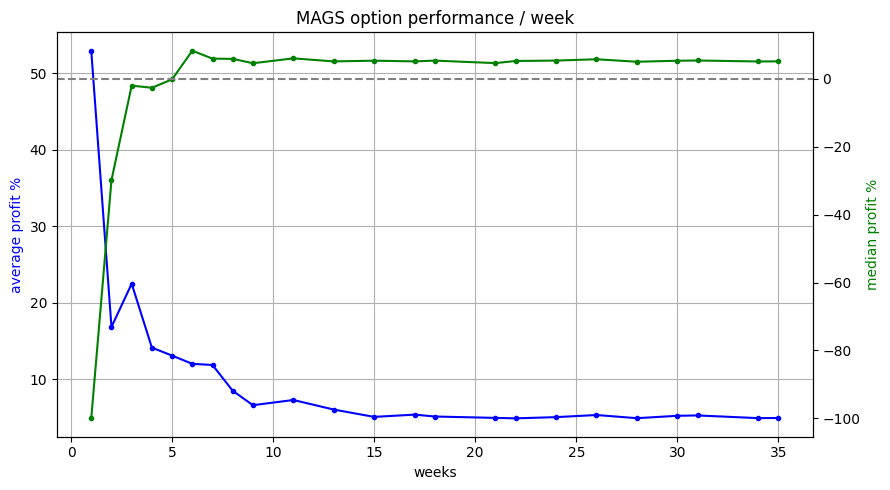

In [15]:
option_weeks = [p[0] for p in option_performance]
option_mean_profit = [p[1] for p in option_performance]
option_median_profit = [p[4] for p in option_performance]

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.', color='b')
ax2.plot(option_weeks, option_median_profit, label='Median option profit', marker='.', color='g')
ax1.set_title(symbol + ' option performance / week')
ax1.set_xlabel('weeks')
ax1.set_ylabel('average profit %', color='b')
ax2.set_ylabel('median profit %', color='g')
ax2.axhline(y=0, color='grey', linestyle='--')
ax1.grid()
plt.tight_layout()
plt.show()

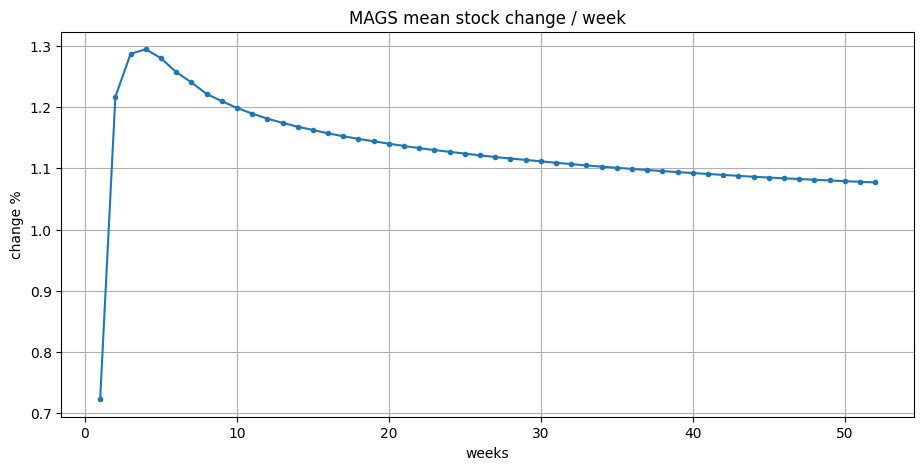

In [16]:
plt.figure(figsize=(11,5))
plt.plot(stock_change, marker='.')
plt.title(symbol + ' mean stock change / week')
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


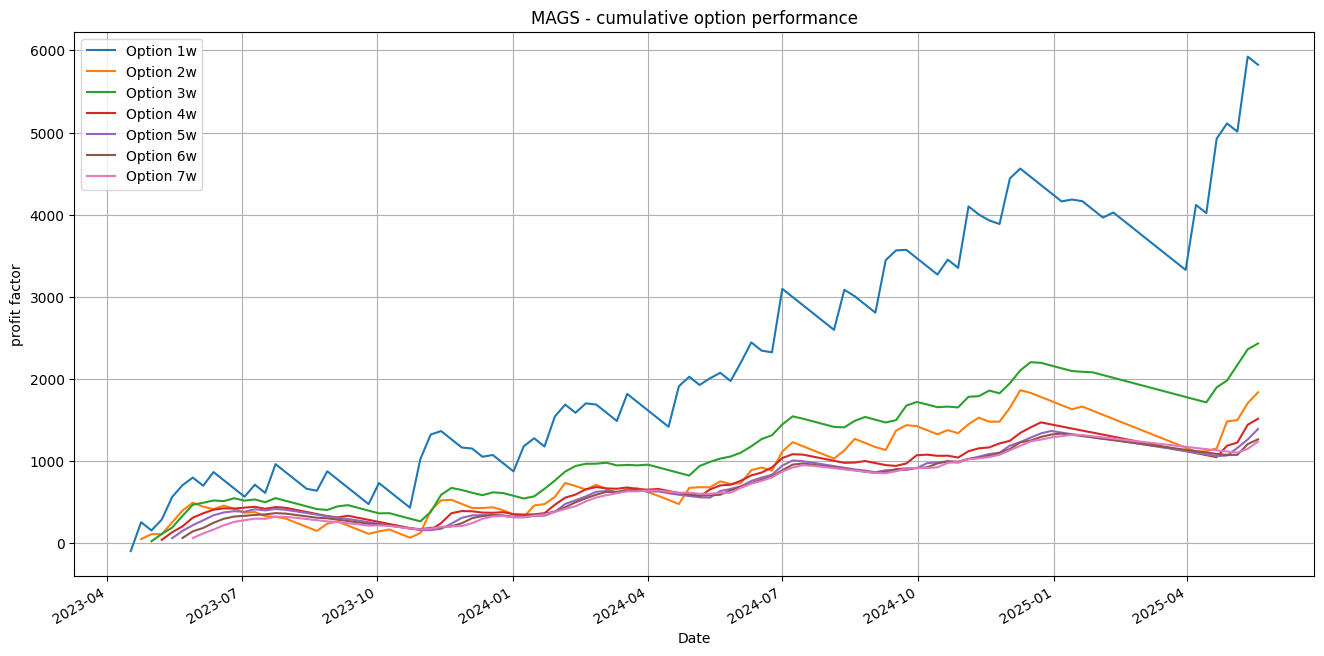

In [21]:
plt.figure(figsize=(16,8))

for w in [1,2,3,4,5,6,7]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend()
plt.title(f'{symbol} - cumulative option performance')
plt.ylabel('profit factor')
plt.grid()
plt.show()


<Axes: title={'center': 'MAGS 1w cumulative option performance'}, xlabel='Date'>

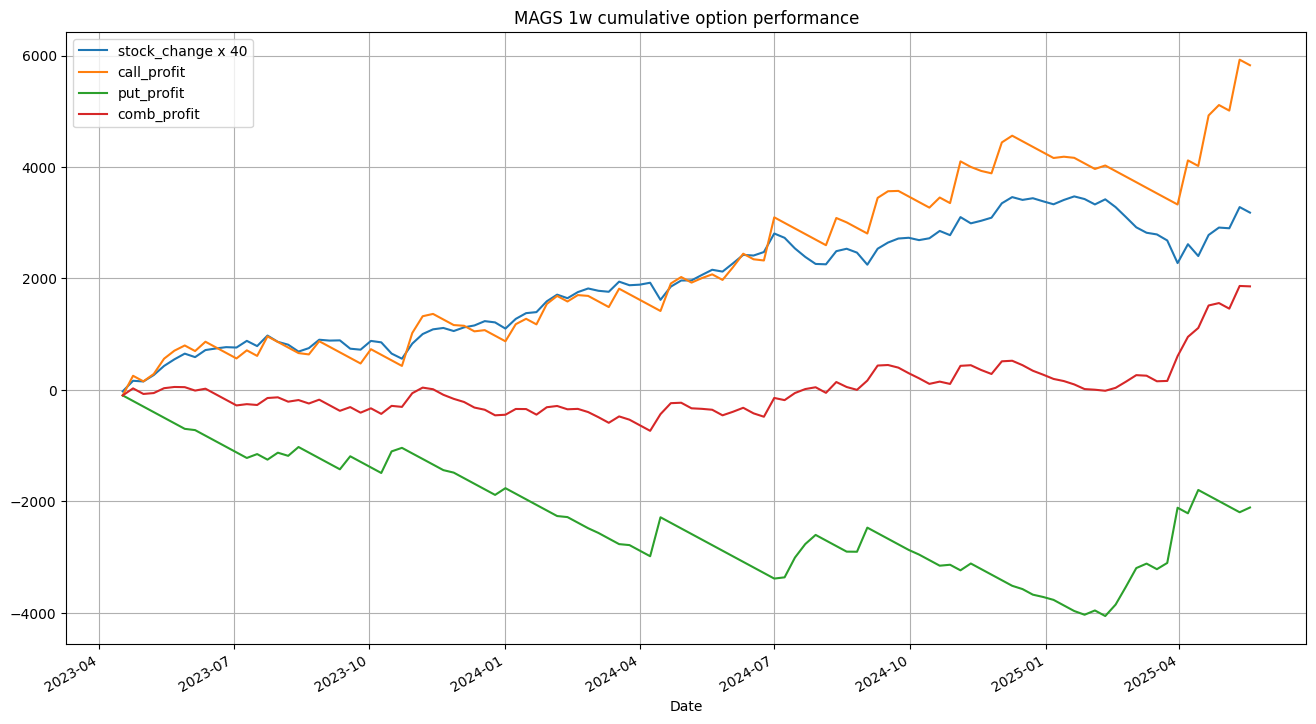

In [18]:
opt_rel_price = 1/option_leverage[1]

history['stock_change'] = history.Close.pct_change(periods=1)
history['call_profit'] = ((history.stock_change - gap/100) / opt_rel_price - 1).clip(lower=-1)*100
history['put_profit'] = ((-history.stock_change - gap/100) / opt_rel_price - 1).clip(lower=-1)*100
history['comb_profit'] = (history.call_profit + history.put_profit) / 2

history['stock_change x 40'] = history['stock_change'] * 100 * 40
history[['stock_change x 40', 'call_profit', 'put_profit', 'comb_profit']].cumsum() \
  .plot(figsize=(16,9), grid=True, title=symbol+' 1w cumulative option performance')